In [159]:
from pprint import pprint
from typing import Optional
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly_football_pitch as pfp
from plotly_football_pitch.pitch_background import PitchBackground
#from plotly_football_pitch.pitch_dimensions import PitchDimensions, PitchOrientation
from plotly_football_pitch import PitchDimensions, PitchOrientation, add_heatmap
from statsbombpy import sb



In [2]:
color_scale = px.colors.sequential.Reds[:1] + px.colors.sequential.Sunsetdark#px.colors.sequential.Reds[1:]

player_name_mapper = {
    'Luis Alberto Suárez Díaz': 'Luis Suárez',
    'Daniel Alves da Silva': 'Alves',
    'Andrés Iniesta Luján': 'Iniesta',
    'Neymar da Silva Santos Junior': 'Neymar Jr.',
    'Munir El Haddadi Mohamed': 'Munir',
    'Sergi Roberto Carnicer': 'Sergi Roberto',
    'Sandro Ramírez Castillo': 'Sandro',
    'Marc Bartra Aregall': 'Marc Bartra',
    'Jordi Alba Ramos': 'Jordi Alba',
    'Gerard Piqué Bernabéu': 'Gerard Piqué',
    'Lionel Andrés Messi Cuccittini': 'Leo Messi',
    'Adriano Correia Claro': 'Adriano',
    'Rafael Alcântara do Nascimento': 'Rafa Alcántara',
    'Sergio Busquets i Burgos': 'Sergio Busquets',
    'Javier Alejandro Mascherano': 'Mascherano',
    'Aleix Vidal Parreu': 'Aleix Vidal'
}

def minute_string_to_float(x, hours=False):
    """
    Translate the minutes from string to float (e.g. '45:30' -> 45.5)
    """
    if hours:
        return int(x.split(':')[0])*60 + int(x.split(':')[1]) + float(x.split(':')[2])/60
    else:
        return int(x.split(':')[0]) + int(x.split(':')[1])/60

def make_pitch_figure(
    dimensions: PitchDimensions,
    marking_colour: str = "black",
    marking_width: int = 4,
    pitch_background: Optional[PitchBackground] = None,
    figure_width_pixels: int = 800,
    figure_height_pixels: int = 600,
    orientation: PitchOrientation = PitchOrientation.HORIZONTAL,
    half=False
) -> go.Figure:
    """Create a plotly figure of a football pitch with markings.

    Some markings which appear in both team's halves e.g. penalty box arc, are
    defined in terms of the attacking team and the defending team. For a
    horizontally oriented pitch the attacking team's half is the left hand one,
    while for a vertically oriented one their half is the bottom one.

    Args:
        dimensions (PitchDimensions): Dimensions of the pitch to plot.
        marking_colour (str): Colour of the pitch markings, default "black".
        marking_width (int): Width of the pitch markings, default 4.
        pitch_background (Optional[PitchBackground]): Strategy for plotting a
            background colour to the pitch. The default of None results in a
            transparent background.
        figure_width_pixels (int): Width of the figure, default 800. This
            corresponds to the long axis of the pitch (pitch length).
        figure_height_pixels (int): Height of the figure, default 600. This
            corresponds to the short axis of the pitch (pitch width).
        orientation (PitchOrientation): Orientation of the pitch, defaults to
            a horizontal pitch.

    Returns:
        plotly.graph_objects.Figure
    """

    if not half:
        return pfp.make_pitch_figure(dimensions, marking_colour, marking_width, pitch_background, figure_width_pixels, figure_height_pixels, orientation)

    dimensions.pitch_length_metres /= 2
    
    pitch_marking_style = {
        "mode": "lines",
        "line": {"color": marking_colour, "width": marking_width},
        "hoverinfo": "skip",
        "showlegend": False,
    }
    spot_style = {
        "mode": "markers",
        "line": {"color": marking_colour},
        "hoverinfo": "skip",
        "showlegend": False,
    }

    touchline = {
        "x": [0, dimensions.pitch_length_metres, dimensions.pitch_length_metres, 0, 0],
        "y": [0, 0, dimensions.pitch_width_metres, dimensions.pitch_width_metres, 0],
    }

    halfway_line = {
        "x": [1, 1],
        "y": [0, 0],
    }

    # attacking team's half is left for horizontal pitches (bottom for
    # vertical after rotation)
    penalty_boxes = {
        "attacking_team": {
            "x": [
                dimensions.pitch_length_metres,
                dimensions.pitch_length_metres - dimensions.penalty_box_length_metres,
                dimensions.pitch_length_metres - dimensions.penalty_box_length_metres,
                dimensions.pitch_length_metres,
            ],
            "y": [
                dimensions.penalty_box_width_min_metres,
                dimensions.penalty_box_width_min_metres,
                dimensions.penalty_box_width_max_metres,
                dimensions.penalty_box_width_max_metres,
            ],
        }
    }

    six_yard_boxes = {
        "attacking_team": {
           "x": [
                dimensions.pitch_length_metres,
                dimensions.pitch_length_metres - (dimensions.six_yard_box_length_metres),
                dimensions.pitch_length_metres - (dimensions.six_yard_box_length_metres),
                dimensions.pitch_length_metres,
            ],
            "y": [
                dimensions.six_yard_box_width_min_metres,
                dimensions.six_yard_box_width_min_metres,
                dimensions.six_yard_box_width_max_metres,
                dimensions.six_yard_box_width_max_metres,
            ],
        }
    }

    penalty_spots = {
        "attacking_team": {
            "x": [
                dimensions.pitch_length_metres - (dimensions.penalty_spot_length_metres)
            ],
            "y": [dimensions.pitch_mid_width_metres],
        }
    }

    centre_spot = {
        "x": [1],
        "y": [dimensions.pitch_mid_width_metres],
    }

    pitch_marking_coordinates_with_style = [
        (touchline, pitch_marking_style),
        (halfway_line, pitch_marking_style),
        (penalty_boxes["attacking_team"], pitch_marking_style),
        #(penalty_boxes["defending_team"], pitch_marking_style),
        (six_yard_boxes["attacking_team"], pitch_marking_style),
        #(six_yard_boxes["defending_team"], pitch_marking_style),
        (penalty_spots["attacking_team"], spot_style),
        #(penalty_spots["defending_team"], spot_style),
        (centre_spot, spot_style),
    ]

    pitch_markings = [
        go.Scatter(
            **orientation.switch_axes_if_required(marking_coordinates),
            **style,
        )
        for marking_coordinates, style in pitch_marking_coordinates_with_style
    ]

    fig = make_subplots()
        
    for markings in pitch_markings:
        fig.add_trace(markings)

    centre_circle = {
        "x0": 1
        + (2*dimensions.centre_circle_radius_metres),
        "y0": dimensions.pitch_mid_width_metres
        + (2*dimensions.centre_circle_radius_metres),
        "x1": 1
        - (2*dimensions.centre_circle_radius_metres),
        "y1": dimensions.pitch_mid_width_metres
        - (2*dimensions.centre_circle_radius_metres),
    }
    fig.add_shape(
        type="circle",
        xref="x",
        yref="y",
        line=pitch_marking_style["line"],
        name=None,
        **orientation.switch_axes_if_required(
            centre_circle, keys_to_switch=[("x0", "y0"), ("x1", "y1")]
        )
    )

    penalty_box_arcs = {
        "attacking_team": {
            "x_centre": dimensions.pitch_length_metres
            - (dimensions.penalty_spot_length_metres),
            "y_centre": dimensions.pitch_mid_width_metres,
        }
    }
    start_angle = {
        "attacking_team": {
            PitchOrientation.HORIZONTAL: 2 * np.pi / 3,
            PitchOrientation.VERTICAL: -5 * np.pi / 6,
        }
    }
    end_angle = {
        "attacking_team": {
            PitchOrientation.HORIZONTAL: 4 * np.pi / 3,
            PitchOrientation.VERTICAL: -np.pi / 6,
        }
    }

    path = pfp.pitch_plot.make_ellipse_arc_svg_path(
        **orientation.switch_axes_if_required(
            penalty_box_arcs["attacking_team"],
            keys_to_switch=[("x_centre", "y_centre")],
        ),
        start_angle=start_angle["attacking_team"][orientation],
        end_angle=end_angle["attacking_team"][orientation],
        a=dimensions.penalty_spot_length_metres,
        b=dimensions.penalty_spot_length_metres,
        num_points=60,
    )
    fig.add_shape(
        type="path",
        path=path,
        line=pitch_marking_style["line"],
        name=None
    )

    if pitch_background is not None:
        fig = pitch_background.add_background(fig, dimensions, orientation)

    axes_ranges = {
        "xaxis_range": [0, dimensions.pitch_length_metres],
        "yaxis_range": [0, dimensions.pitch_width_metres],
    }

    fig.update_layout(
        height=figure_height_pixels,
        width=figure_width_pixels,
        **orientation.switch_axes_if_required(
            axes_ranges, keys_to_switch=[("xaxis_range", "yaxis_range")]
        )
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    return fig

#dimensions = PitchDimensions()
#fig = make_pitch_figure(dimensions, half=True, figure_height_pixels=680, figure_width_pixels=535)

In [3]:
# Get all competition and season matches
competition_row = sb.competitions()[
    (sb.competitions()['competition_name'] == 'La Liga') 
    & (sb.competitions()['season_name'] == '2015/2016')
]
competition_id = pd.unique(
    competition_row['competition_id']
)[0]
season_id = pd.unique(
    competition_row['season_id']
)[0]

matches = sb.matches(competition_id=competition_id, season_id=season_id)
all_teams = sorted(pd.unique(matches['home_team']))
print('All teams:\n', all_teams)

All teams:
 ['Athletic Club', 'Atlético Madrid', 'Barcelona', 'Celta Vigo', 'Eibar', 'Espanyol', 'Getafe', 'Granada', 'Las Palmas', 'Levante UD', 'Málaga', 'RC Deportivo La Coruña', 'Rayo Vallecano', 'Real Betis', 'Real Madrid', 'Real Sociedad', 'Sevilla', 'Sporting Gijón', 'Valencia', 'Villarreal']


In [4]:
matches[(matches['home_team']=='Barcelona') & (matches['away_team']=='Real Madrid')]

match_id  match_date      kick_off      competition     season  \
349    267533  2016-04-02  20:30:00.000  Spain - La Liga  2015/2016   

     home_team    away_team  home_score  away_score match_status  ...  \
349  Barcelona  Real Madrid           1           2    available  ...   

            last_updated_360 match_week competition_stage           stadium  \
349  2021-06-13T16:17:31.694         31    Regular Season  Spotify Camp Nou   

    referee                 home_managers    away_managers data_version  \
349     NaN  Luis Enrique Martínez García  Zinédine Zidane        1.1.0   

    shot_fidelity_version xy_fidelity_version  
349                     2                   2  

[1 rows x 22 columns]

In [5]:
# Get all events (potser centrarnos en un subset de jugadors?)
all_events = None

for team in ['Barcelona']: # all_teams:
    team_matches = matches[(matches['home_team'] == team) | (matches['away_team'] == team)]
    
    minutes = {} # match_id: minutes
    for match_id in pd.unique(team_matches['match_id']):
        match_events = sb.events(match_id=match_id)
        match_events['minutes'] = match_events[
            (match_events['type'] == 'Half End') 
            & (match_events['team'] == team)
        ]['timestamp'].apply(lambda x: minute_string_to_float(x, True)).sum()
        
        if all_events is None:
            all_events = match_events.copy()
        else:
            all_events = pd.concat([all_events, match_events], join="inner")

all_events = all_events.merge(matches[['match_id', 'match_date']], on='match_id')
all_events.replace({'player': player_name_mapper}, inplace=True)
all_events['x'] = all_events['location'].apply(lambda x: x[0] if not isinstance(x, float) else x)
all_events['y'] = all_events['location'].apply(lambda x: x[1] if not isinstance(x, float) else x)
all_events['time'] =  all_events.apply(lambda x: f"{str(x['minute']).zfill(2)}:{str(x['second']).zfill(2)}", axis=1)
all_events['float_time'] = all_events.minute + (all_events.second/60)

all_events

ball_receipt_outcome ball_recovery_recovery_failure carry_end_location  \
0                       NaN                            NaN                NaN   
1                       NaN                            NaN                NaN   
2                       NaN                            NaN                NaN   
3                       NaN                            NaN                NaN   
4                       NaN                            NaN                NaN   
...                     ...                            ...                ...   
138617                  NaN                            NaN                NaN   
138618                  NaN                            NaN                NaN   
138619                  NaN                            NaN                NaN   
138620                  NaN                            NaN                NaN   
138621                  NaN                            NaN                NaN   

       clearance_aerial_won clearance_body_part clearance_head  \
0                       NaN                 NaN            NaN   
1                       NaN                 NaN            NaN   
2                       NaN                 NaN            NaN   
3                       NaN                 NaN            NaN   
4                       NaN                 NaN            NaN   
...                     ...                 ...            ...   
138617                  NaN                 NaN            NaN   
138618                  NaN                 NaN            NaN   
138619                  NaN                 NaN            NaN   
138620                  NaN                 NaN            NaN   
138621                  NaN                 NaN            NaN   

       clearance_left_foot clearance_right_foot counterpress dribble_outcome  \
0                      NaN                  NaN          NaN             NaN   
1                      NaN                  NaN          NaN             NaN   
2                      NaN                  NaN          NaN             NaN   
3                      NaN                  NaN          NaN             NaN   
4                      NaN                  NaN          NaN             NaN   
...                    ...                  ...          ...             ...   
138617                 NaN                  NaN          NaN             NaN   
138618                 NaN                  NaN          NaN             NaN   
138619                 NaN                  NaN          NaN             NaN   
138620                 NaN                  NaN          NaN             NaN   
138621                 NaN                  NaN          NaN             NaN   

        ... team_id     timestamp            type under_pressure    minutes  \
0       ...     217  00:00:00.000     Starting XI            NaN  92.025350   
1       ...     222  00:00:00.000     Starting XI            NaN  92.025350   
2       ...     222  00:00:00.000      Half Start            NaN  92.025350   
3       ...     217  00:00:00.000      Half Start            NaN  92.025350   
4       ...     222  00:00:00.000      Half Start            NaN  92.025350   
...     ...     ...           ...             ...            ...        ...   
138617  ...     207  00:14:28.134    Substitution            NaN  93.473067   
138618  ...     207  00:28:41.279    Substitution            NaN  93.473067   
138619  ...     207  00:42:57.079    Substitution            NaN  93.473067   
138620  ...     217  00:19:33.595           Error            NaN  93.473067   
138621  ...     207  00:31:46.006  Tactical Shift            NaN  93.473067   

        match_date    x     y   time float_time  
0       2015-11-08  NaN   NaN  00:00   0.000000  
1       2015-11-08  NaN   NaN  00:00   0.000000  
2       2015-11-08  NaN   NaN  00:00   0.000000  
3       2015-11-08  NaN   NaN  00:00   0.000000  
4       2015-11-08  NaN   NaN  45:00  45.000000  
...            ...  ...   ...  

In [42]:
# Keep only team shots
shots = all_events.loc[
    (all_events['type'] == 'Shot') 
    & (all_events['team'] == team) 
    & (all_events['shot_type'] == 'Open Play')
].set_index('id')

shots['goal'] = shots['shot_outcome'] == 'Goal'

columns = ['match_id', 'x', 'y', 'minute', 'second', 'player', 'position', 'shot_outcome', 'shot_type', 'minutes', 'time', 'goal', 'shot_statsbomb_xg']
shots = shots[columns]

# Remove this line below
old_shots = shots.copy()

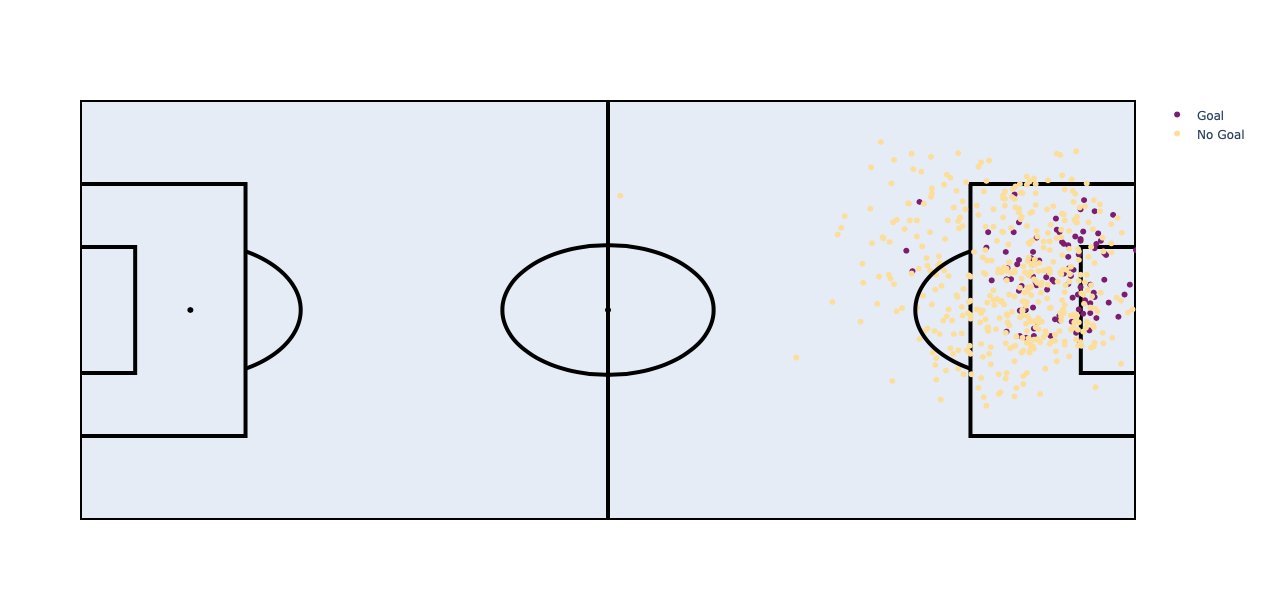

In [7]:
# Plotting
#!pipenv install plotly==5.17.0
#!pipenv install "ipywidgets>=7.6"
#!pipenv install plotly-football-pitch

#import plotly.express as px

dimensions = PitchDimensions()
fig = make_pitch_figure(dimensions)

# scale the data to pitch dimensions
shots = old_shots.copy()

shots['x'] = (shots['x'] - 0) / (shots['x'].max() - 0) * (dimensions.pitch_length_metres - 0) + 0
#(shots['x'] - 0) / (shots['x'].max() - 0) * (dimensions.pitch_length_metres - 0) + 0
#shots = shots[shots['player'] == 'Leo Messi']

for i, group in enumerate([True, False]):

    color_index = len(color_scale)-1-i if i%2 == 0 else i
    
    fig.add_trace(go.Scatter(
        x=shots[shots['goal'] == group]['x'],
        y=shots[shots['goal'] == group]['y'],
        mode="markers",
        name='Goal' if group else 'No Goal',
        marker_color=color_scale[color_index]
    ))

fig.show()

PitchDimensions(pitch_width_metres=68, pitch_length_metres=52.5)


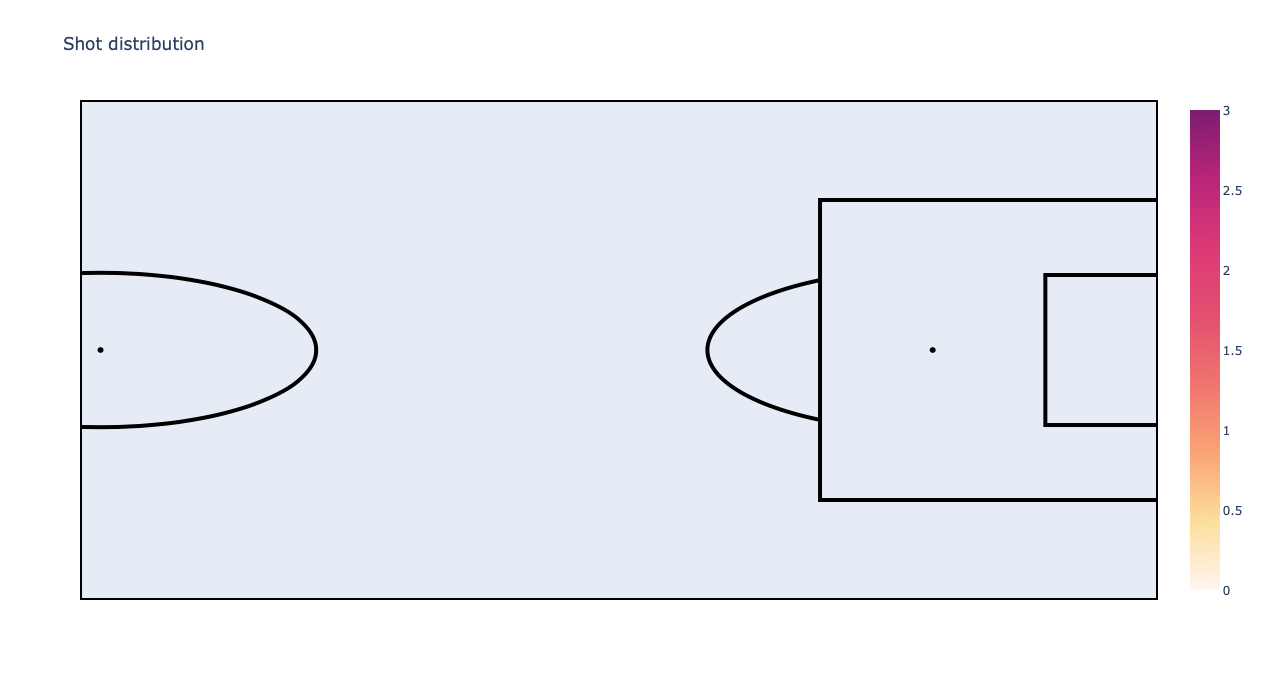

In [8]:
## SHOT DISTRIBUTION

div_factor = 1
player = 'Leo Messi'

dimensions = PitchDimensions()
fig = make_pitch_figure(dimensions, half=True, figure_height_pixels=680, figure_width_pixels=535)
print(dimensions)

# As we're using half a pitch, we have to scale the data: x between [0,120] -> x between [0, 52.5]
shots = old_shots.copy()
shots['x'] = (shots['x'] - shots['x'].min()) / (shots['x'].max() - shots['x'].min()) * (dimensions.pitch_length_metres - 0) + 0

player_shots = shots[(shots['player'] == player)]

xy = div_factor * (player_shots[['x', 'y', 'goal']]/div_factor).round()
xy = xy.groupby(['x', 'y']).count()[['goal']]

data = []
# data = [
#    [y1x1, y1x2, y1x3...],
#    [y2x1, y2x2, y2x3...],
#]
for j in range(0, dimensions.pitch_width_metres+div_factor, div_factor):
    for i in range(0, int(dimensions.pitch_length_metres)+div_factor, div_factor):
        #print(j, i)
        if i == 0 and j != dimensions.pitch_width_metres:
            data += [[]]
        try:
            if (i, j) in xy.index:
                data[int(j/div_factor)].append(xy.loc[(i,j)].values[0])
            else:
                data[int(j/div_factor)].append(0)
        except:
            pass
            
fig = add_heatmap(fig, np.asarray(data), zsmooth='best', colorscale=color_scale)
"""
fig.add_trace(go.Scatter(
        x=player_shots['x']-3,
        y=player_shots['y']-3,
        mode="markers",
        marker_color='#30106B'
))
"""
fig.update_layout(
    title='Shot distribution'
)
fig.show()

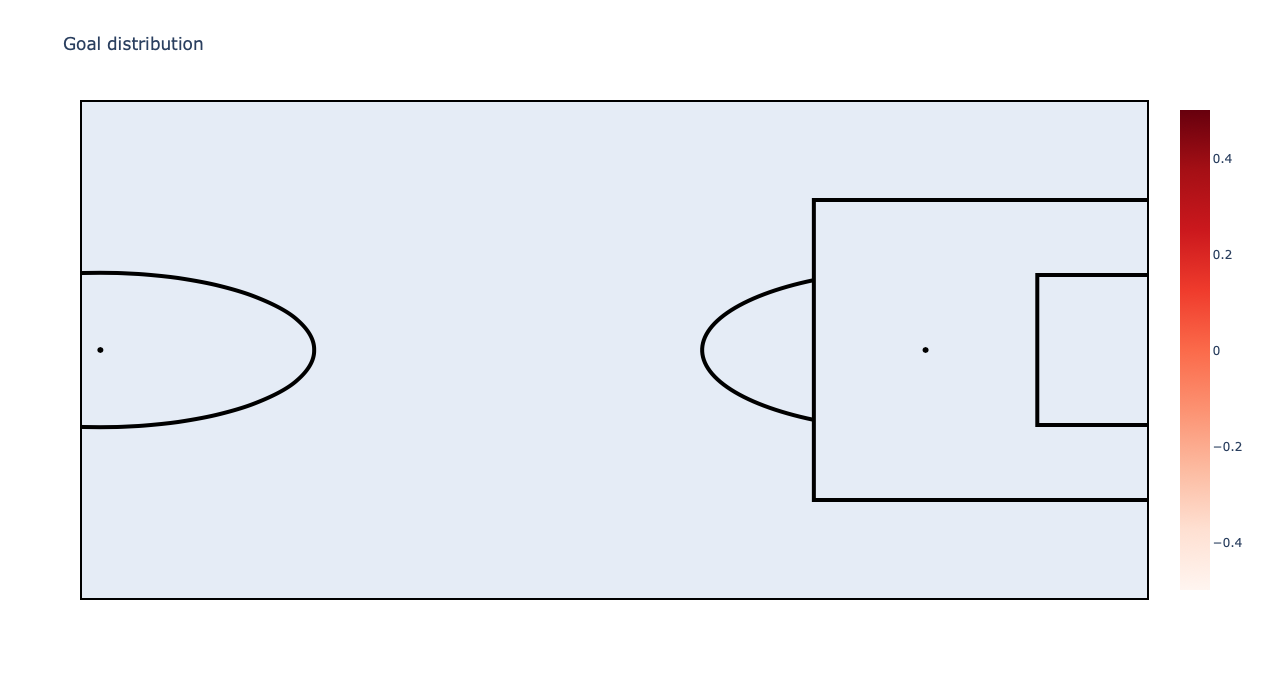

In [15]:
## GOAL DISTRIBUTION

div_factor = 5
player = 'Leo Messi'

dimensions = PitchDimensions()
fig = make_pitch_figure(dimensions, half=True, figure_height_pixels=680, figure_width_pixels=535)

player_goals = shots[(shots['shot_outcome'] == 'Goal') & (shots['player'] == player)]

data = []
# data = [
#    [y1x1, y1x2, y1x3...],
#    [y2x1, y2x2, y2x3...],
#]

if not player_goals.empty:
# As we're using half a pitch, we have to scale the data: x between [0,120] -> x between [0, 52.5]
    #player_goals['x'] = (player_goals['x'] - 60) / (120 - 60) * (dimensions.pitch_length_metres/2 - 0) + 0
    
    xy = div_factor * (player_goals[['x', 'y', 'goal']]/div_factor).round()
    xy = xy.groupby(['x', 'y']).count()[['goal']]
    
    for j in range(0, dimensions.pitch_width_metres+div_factor, div_factor):
        for i in range(0, int(dimensions.pitch_length_metres/2)+div_factor, div_factor):
            #print(j, i)
            if i == 0 and j != dimensions.pitch_width_metres:
                data += [[]]
            try:
                if (i, j) in xy.index:
                    data[int(j/div_factor)].append(xy.loc[(i,j)].values[0])
                else:
                    data[int(j/div_factor)].append(0)
            except:
                pass
            
    fig = add_heatmap(fig, np.asarray(data), zsmooth='best')
    fig.update_layout(
        title='Goal distribution'
    )
    fig.show()
else:
    print(f"{player} didn't score any goals that season")

In [14]:
shots[(shots['shot_outcome'] == 'Goal') & (shots['player'] == player)]

match_id          x     y  minute  \
id                                                                        
b8597aa2-d318-4ee7-ba99-521e532a9d5e    266498 -13.236988  40.3      39   
e8b56951-eec6-4a63-8bd0-9e505410045e    266310  -8.572686  41.4      72   
8dd694f6-8993-485b-997c-a9f8b97bb02c    267576  -7.240028  37.3      29   
d02078ff-a25b-4ac2-bbdc-55cae3d80785    266653  -7.867161  34.4      22   
602e6932-ef9d-4c48-88cf-f79ea806375b    266653  -7.279224  39.3      52   
1495cb78-9c0d-4d26-9502-fe5a5881a3c1    266653  -9.082231  43.4      71   
c155853d-1685-47ba-a755-58f8282b3873    265944  -9.944539  44.1      11   
82b83f49-9e9b-4dcb-857c-fcb650fbf129    265894  -5.750587  45.2      50   
3d71df7f-846c-4ea9-b118-35109b3479fd    266885  -5.045062  44.7      90   
6ad94df9-ffdd-4d1f-a87e-117734f5ea46    266815 -13.511359  43.6      24   
740c6149-c707-4747-8b05-0ae57a12d283    266815  -6.848070  48.8      30   
d01376b4-be3f-4cbe-b584-d8a6d37d2930    266620  -5.868174  36.5       7   
e8c495dc-b757-4fe9-8cc1-023257fac4e4    266620  -4.065166  32.9      13   
950206c9-98a7-4315-a2e0-cb99148da851    266620  -6.181741  39.5      57   
2239614b-7704-4908-9a8c-88bb504023b8    266056  -9.043035  30.5      41   
4f0ed81c-4a9a-4a18-8ac7-e68ed0db16f2    267327  -6.299328  38.2      32   
e6b1dfb0-cb3f-4be2-a4f0-639e92ce1581    266166  -6.887265  32.5      76   
bd6630f8-66d3-4ec4-a126-d087d0a2de70    266490  -9.709364  38.8      89   
800279c5-2275-469f-b2c3-4836fb731efa    266557  -7.749573  38.5      62   

                                      second     player  \
id                                                        
b8597aa2-d318-4ee7-ba99-521e532a9d5e      58  Leo Messi   
e8b56951-eec6-4a63-8bd0-9e505410045e      26  Leo Messi   
8dd694f6-8993-485b-997c-a9f8b97bb02c      36  Leo Messi   
d02078ff-a25b-4ac2-bbdc-55cae3d80785      58  Leo Messi   
602e6932-ef9d-4c48-88cf-f79ea806375b      52  Leo Messi   
1495cb78-9c0d-4d26-9502-fe5a5881a3c1       2  Leo Messi   
c155853d-1685-47ba-a755-58f8282b3873      57  Leo Messi   
82b83f49-9e9b-4dcb-857c-fcb650fbf129      54  Leo Messi   
3d71df7f-846c-4ea9-b118-35109b3479fd      13  Leo Messi   
6ad94df9-ffdd-4d1f-a87e-117734f5ea46      20  Leo Messi   
740c6149-c707-4747-8b05-0ae57a12d283      16  Leo Messi   
d01376b4-be3f-4cbe-b584-d8a6d37d2930       7  Leo Messi   
e8c495dc-b757-4fe9-8cc1-023257fac4e4      39  Leo Messi   
950206c9-98a7-4315-a2e0-cb99148da851      36  Leo Messi   
2239614b-7704-4908-9a8c-88bb504023b8       1  Leo Messi   
4f0ed81c-4a9a-4a18-8ac7-e68ed0db16f2      54  Leo Messi   
e6b1dfb0-cb3f-4be2-a4f0-639e92ce1581      26  Leo Messi   
bd6630f8-66d3-4ec4-a126-d087d0a2de70      15  Leo Messi   
800279c5-2275-469f-b2c3-4836fb731efa      57  Leo Messi   

                                                       position shot_outcome  \
id                                                                             
b8597aa2-d318-4ee7-ba99-521e532a9d5e                 Right Wing         Goal   
e8b56951-eec6-4a63-8bd0-9e505410045e                 Right Wing         Goal   
8dd694f6-8993-485b-997c-a9f8b97bb02c                 Right Wing         Goal   
d02078ff-a25b-4ac2-bbdc-55cae3d80785                 Right Wing         Goal   
602e6932-ef9d-4c48-88cf-f79ea806375b                 Right Wing         Goal   
1495cb78-9c0d-4d26-9502-fe5a5881a3c1                 Right Wing         Goal   
c155853d-1685-47ba-a755-58f8282b3873                 Right Wing         Goal   
82b83f49-9e9b-4dcb-857c-fcb650fbf129                 Right Wing         Goal   
3d71df7f-846c-4ea9-b118-35109b3479fd                 Right Wing         Goal   
6ad94df9-ffdd-4d1f-a87e-117734f5ea46                 Right Wing         Goal   
740c6149-c707-4747-8b05-0ae57a12d283                 Right Wing         Goal   
d01376b4-be3f-4cbe-b584-d8a6d37d2930                 Right Wing         Goal   
e8c495dc-b757-4fe9-8cc1-023257fac4e4                 Right Wing         Goal   
950206c9-98a7-4315-a2e

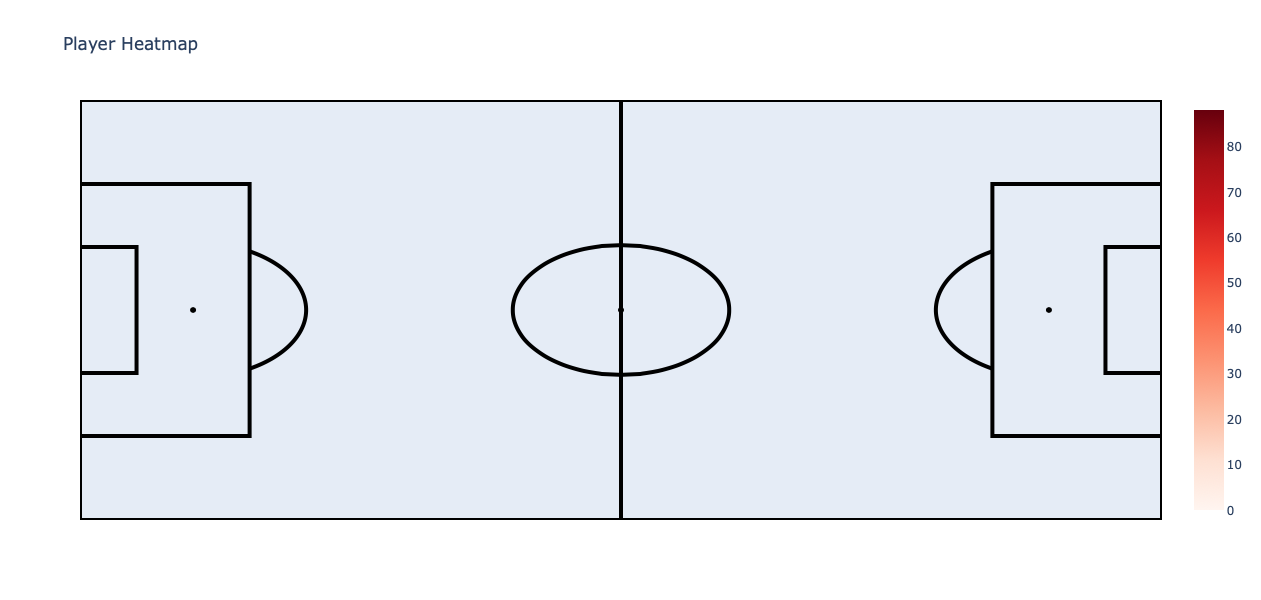

In [17]:
## PLAYER HEATMAP

div_factor = 3
player = 'Neymar Jr.'

dimensions = PitchDimensions()
fig = make_pitch_figure(dimensions)

# Potser puc treure les jugades a joc parat?
player_events = all_events[(all_events['player'] == player) & (~all_events['location'].isna())] 

#player_events['x'] = (player_events['x'] - 0) / (player_events['x'].max() - 0) * (dimensions.pitch_length_metres - 0) + 0

xy = div_factor * (player_events[['x', 'y', 'minutes']]/div_factor).round()
xy = xy.groupby(['x', 'y']).count()[['minutes']]

data = []
for j in range(0, dimensions.pitch_width_metres+div_factor, div_factor):
    for i in range(0, int(dimensions.pitch_length_metres)+div_factor, div_factor):
        #print(j, i)
        if i == 0 and j != dimensions.pitch_width_metres:
            data += [[]]
        try:
            if (i, j) in xy.index:
                data[int(j/div_factor)].append(xy.loc[(i,j)].values[0])
            else:
                data[int(j/div_factor)].append(0)
        except:
            pass
            
fig = add_heatmap(fig, np.asarray(data), zsmooth='best')
fig.update_layout(
    title='Player Heatmap'
)
fig.show()

In [33]:
## SHOTS BY TIME FRAME
div_factor = 15
player = 'Neymar Jr.'

fig = make_subplots()

for player in shots.player.unique():

    player_shots = shots[(shots['player'] == player)]
    
    xy = div_factor * (player_shots[['float_time', 'minutes']]/div_factor).round()
    xy = xy.groupby(['float_time']).count()[['minutes']]
    
    fig.add_trace(
        go.Scatter(
            name=player,
            x = xy.index, 
            y = xy.minutes,
            mode='lines'
        )
    )

# Add avg
xy = div_factor * (shots[['float_time', 'minutes']]/div_factor).round()
xy = xy.groupby(['float_time']).count()[['minutes']]/len(shots.player.unique())

fig.add_trace(
    go.Scatter(
        name='Sample Average',
        x = xy.index, 
        y = xy.minutes,
        line = go.scatter.Line(dash='dash'),
        marker=None,
        mode='lines'
    )
)

fig.update_xaxes(range=[0, 91])
fig.update_layout(
    title='Shots by Quarter',
    xaxis = dict(
        tickmode = 'array',
        tickvals = xy.index.values
    )
)
fig.show()

KeyError: "['float_time'] not in index"

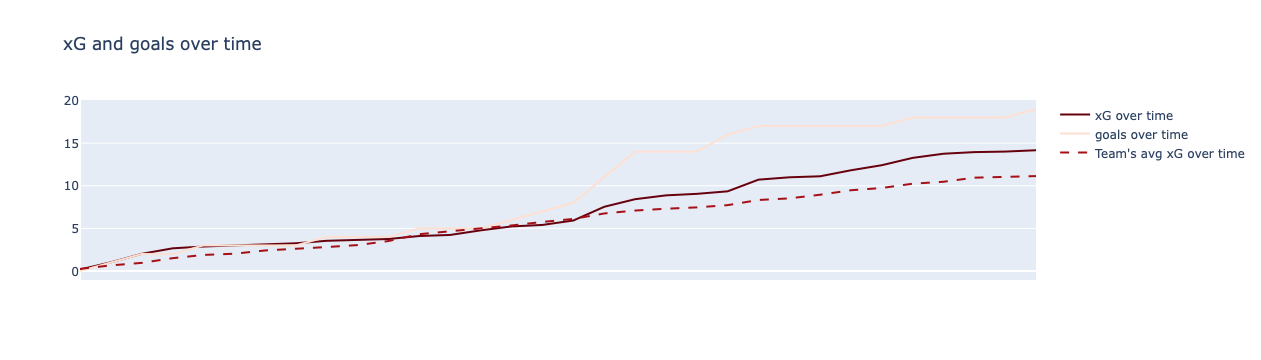

In [639]:
## Goals vs expected goals
player = 'Leo Messi'
player_shots = shots[shots['player'] == player]
#goals_vs_expected = pd.merge(player_shots.groupby(['match_id', 'player'])[['shot_statsbomb_xg']].mean(), player_shots.groupby(['match_id', 'player'])[['goal']].sum(), on=['match_id', 'player'])
goals_vs_expected = player_shots.groupby(['match_id', 'player'])[['shot_statsbomb_xg', 'goal']].sum()

# Add cum values
goals_vs_expected['cum_goal'] = goals_vs_expected['goal'].cumsum()
goals_vs_expected['cum_shot_statsbomb_xg'] = goals_vs_expected['shot_statsbomb_xg'].cumsum()

# Compute team's avg xg and cumsum it
team_avg_xg = pd.merge(shots.groupby('match_id')[['shot_statsbomb_xg']].sum(), shots.groupby('match_id')[['player']].nunique(), on='match_id')
team_avg_xg['team_avg_xg'] = team_avg_xg['shot_statsbomb_xg']/team_avg_xg['player']
goals_vs_expected = goals_vs_expected.merge(team_avg_xg, on='match_id')
goals_vs_expected['cum_team_avg_xg'] = team_avg_xg['team_avg_xg'].cumsum()

color_index = len(color_scale)-1-i if i%2 == 0 else i

fig = go.Figure(data=[
    go.Scatter(
        name='xG over time', 
        x = [*range(len(goals_vs_expected.index.get_level_values(0)))], 
        y=goals_vs_expected['cum_shot_statsbomb_xg'],
        marker_color=color_scale[-1]
    ),
    go.Scatter(
        name='goals over time', 
        x = [*range(len(goals_vs_expected.index.get_level_values(0)))], 
        y=goals_vs_expected['cum_goal'],
        marker_color=color_scale[0]
    ),
    go.Scatter(
        name="Team's avg xG over time", 
        x = [*range(len(goals_vs_expected.index.get_level_values(0)))], 
        y=goals_vs_expected['cum_team_avg_xg'], 
        line = go.scatter.Line(dash='dash'),
        marker_color=color_scale[-2]
    ),
    
])

fig.update_layout(
    title='xG and goals over time',
    xaxis = dict(
        tickmode = 'array',
        tickvals = xy.index.values
    )
)

fig.show()

In [617]:
team_avg_xg = pd.merge(shots.groupby('match_id')[['shot_statsbomb_xg']].sum(), shots.groupby('match_id')[['player']].nunique(), on='match_id')
team_avg_xg['teams_avg_xg'] = team_avg_xg['shot_statsbomb_xg']/team_avg_xg['player']
team_avg_xg

shot_statsbomb_xg  player        xg
match_id                                     
265839             1.982146       8  0.247768
265894             2.051562       5  0.410312
265944             2.363140       8  0.295393
265958             2.745182       5  0.549036
266056             1.526332       4  0.381583
266106             0.992816       7  0.141831
266149             1.910292       5  0.382058
266160             1.014914       6  0.169152
266166             1.624927       7  0.232132
266236             0.920628       4  0.230157
266254             3.302197       7  0.471742
266310             4.034037       5  0.806807
266424             2.362848       7  0.337550
266467             1.910314       5  0.382063
266490             1.837064       6  0.306177
266498             2.056616       5  0.411323
266557             2.125320       6  0.354220
266620             3.200393       5  0.640079
266653             2.724717       8  0.340590
266664             1.068325       5  0.213665
266670             0.944974       6  0.157496
266815             1.579335       6  0.263222
266885             2.417736       4  0.604434
266961             0.947525       5  0.189505
266986             2.133912       5  0.426782
267273             2.635041       5  0.527008
267274             1.317613       5  0.263523
267327             2.517183       5  0.503437
267422             1.827960       8  0.228495
267506             2.391793       5  0.478359
267533             0.646202       8  0.080775
267576             0.531957       5  0.106391
267611             1.202198       7  0.171743
3825617            2.564698       7  0.366385
3825627            3.037334       5  0.607467
3825637            1.534356       5  0.306871
3825645            1.974760       7  0.282109
3825660            2.086344       7  0.298049

In [619]:
shots.groupby('match_id')[['shot_statsbomb_xg']].mean()

shot_statsbomb_xg
match_id                   
265839             0.141582
265894             0.227951
265944             0.124376
265958             0.249562
266056             0.190791
266106             0.070915
266149             0.112370
266160             0.112768
266166             0.135411
266236             0.115078
266254             0.206387
266310             0.237296
266424             0.157523
266467             0.112371
266490             0.114817
266498             0.171385
266557             0.106266
266620             0.200025
266653             0.143406
266664             0.097120
266670             0.118122
266815             0.098708
266885             0.219794
266961             0.055737
266986             0.177826
267273             0.239549
267274             0.087841
267327             0.209765
267422             0.079477
267506             0.239179
267533             0.053850
267576             0.066495
267611             0.092477
3825617            0.098642
3825627            0.276121
3825637            0.139487
3825645            0.141054
3825660            0.109808

In [71]:
import copy
from functions import get_player_shots, prepare_team_data, make_pitch_figure

EVENTS, SHOTS, GOALS = prepare_team_data()
DIMENSIONS = PitchDimensions()

match_id = 267533
match_shots = SHOTS[SHOTS['match_id'] == match_id]
match_shots

match_id      x     y  float_time  \
id                                                                        
bd061622-94bc-4367-b68b-ee4c2c7a10a4    267533  101.2  33.2   16.300000   
afe00df7-fd1c-489f-beb6-11d698fd739b    267533  103.1  42.0   18.900000   
b8e767d0-d0cd-4e89-966d-aadd8c05a388    267533  102.4  28.5   21.633333   
33fa3c9a-db7e-4c7f-ba55-e00a9fc9c5db    267533  102.1  57.2   41.433333   
69795747-bca8-4f26-a2a0-b2191e6867da    267533   94.2  51.2   45.366667   
1c818a8f-aabc-4ccb-9b26-0032deba1cb0    267533   91.0  61.2   53.133333   
945c0c9e-3df6-4b38-a9e4-7f50cd0e87dd    267533  102.6  33.9   53.950000   
78f4c78f-0fc8-493b-9321-bdad695a9d36    267533  112.3  42.6   55.750000   
78178271-bfef-4706-a122-dc21d4b124f3    267533  103.6  42.0   69.866667   
c3b99c27-8c58-46a7-9163-7b63696fa9fc    267533  111.0  59.3   79.266667   
d61bd461-9ddc-466f-9a4e-8aec10e58183    267533  105.5  44.6   83.800000   
d847e843-7caf-439d-a969-edea4475a938    267533  108.5  41.3   91.616667   

                                            player shot_outcome  shot_type  \
id                                                                           
bd061622-94bc-4367-b68b-ee4c2c7a10a4       Iniesta      Blocked  Open Play   
afe00df7-fd1c-489f-beb6-11d698fd739b  Ivan Rakitić        Saved  Open Play   
b8e767d0-d0cd-4e89-966d-aadd8c05a388        Neymar        Off T  Open Play   
33fa3c9a-db7e-4c7f-ba55-e00a9fc9c5db         Alves        Off T  Open Play   
69795747-bca8-4f26-a2a0-b2191e6867da  Ivan Rakitić        Off T  Open Play   
1c818a8f-aabc-4ccb-9b26-0032deba1cb0         Alves      Blocked  Open Play   
945c0c9e-3df6-4b38-a9e4-7f50cd0e87dd     Leo Messi        Saved  Open Play   
78f4c78f-0fc8-493b-9321-bdad695a9d36  Gerard Piqué         Goal  Open Play   
78178271-bfef-4706-a122-dc21d4b124f3   Luis Suárez      Blocked  Open Play   
c3b99c27-8c58-46a7-9163-7b63696fa9fc   Luis Suárez        Off T  Open Play   
d61bd461-9ddc-466f-9a4e-8aec10e58183   Luis Suárez        Off T  Open Play   
d847e843-7caf-439d-a969-edea4475a938    Arda Turan      Blocked  Open Play   

                                      minutes   goal  shot_statsbomb_xg  
id                                                                       
bd061622-94bc-4367-b68b-ee4c2c7a10a4  93.0549  False           0.078174  
afe00df7-fd1c-489f-beb6-11d698fd739b  93.0549  False           0.063073  
b8e767d0-d0cd-4e89-966d-aadd8c05a388  93.0549  False           0.049375  
33fa3c9a-db7e-4c7f-ba55-e00a9fc9c5db  93.0549  False           0.026043  
69795747-bca8-4f26-a2a0-b2191e6867da  93.0549  False           0.021533  
1c818a8f-aabc-4ccb-9b26-0032deba1cb0  93.0549  False           0.005735  
945c0c9e-3df6-4b38-a9e4-7f50cd0e87dd  93.0549  False           0.062282  
78f4c78f-0fc8-493b-9321-bdad695a9d36  93.0549   True           0.108388  
78178271-bfef-4706-a122-dc21d4b124f3  93.0549  False           0.046139  
c3b99c27-8c58-46a7-9163-7b63696fa9fc  93.0549  False           0.009944  
d61bd461-9ddc-466f-9a4e-8aec10e58183  93.0549  False           0.060023  
d847e843-7caf-439d-a969-edea4475a938  93.0549  False           0.115493

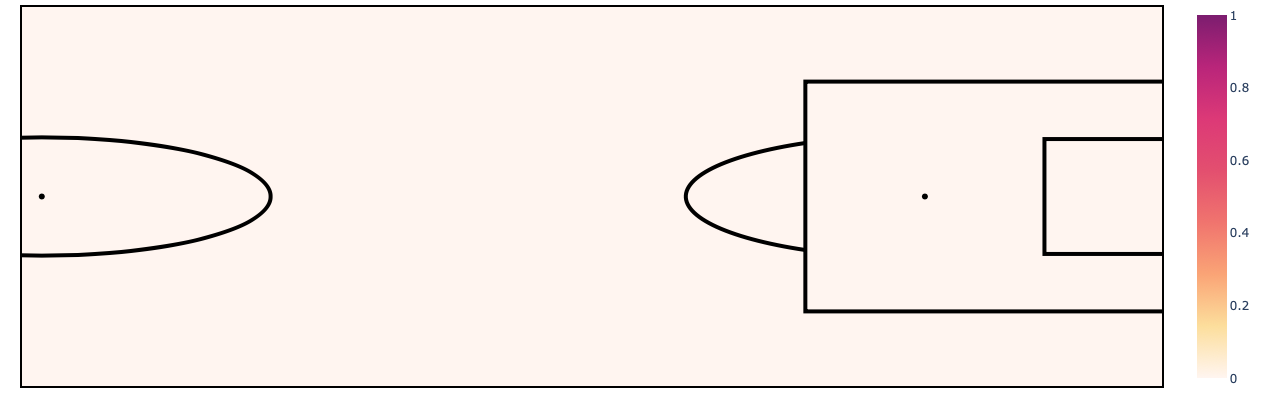

In [72]:
def get_player_shots(player:str, shots, dimensions):

    ## Scale x to dimensions
    shots['x'] = (shots['x'] - 0) / (shots['x'].max() - 0) * (dimensions.pitch_length_metres - 0) + 0
    #shots['y'] = (shots['y'] - 0) / (shots['y'].max() - 0) * (dimensions.pitch_width_metres - 0) + 0

    if player != 'All players':
        return shots[shots['player'] == player]

    return shots


match_id = 267533
match_shots = SHOTS[SHOTS['match_id'] == match_id]
div_factor=1
COLOR_SCALE = px.colors.sequential.Reds[:1] + px.colors.sequential.Sunsetdark
half_pitch_dimensions = copy.deepcopy(DIMENSIONS)
fig = make_pitch_figure(half_pitch_dimensions, half=True, figure_height_pixels=680, figure_width_pixels=535, ratio=0.6)

shots = get_player_shots('Gerard Piqué', match_shots, half_pitch_dimensions)

xy = div_factor * (shots[['x', 'y', 'goal']]/div_factor).round()
xy = xy.groupby(['x', 'y']).count()[['goal']]

data = []
for j in range(0, half_pitch_dimensions.pitch_width_metres+div_factor, div_factor):
    for i in range(0, int(half_pitch_dimensions.pitch_length_metres)+div_factor, div_factor):
        #print(j, i)
        if i == 0 and j != half_pitch_dimensions.pitch_width_metres:
            data += [[]]
        try:
            if (i, j) in xy.index:
                data[int(j/div_factor)].append(xy.loc[(i,j)].values[0])
            else:
                data[int(j/div_factor)].append(0)
        except:
            pass
        
if np.asarray(data).any():
    fig = add_heatmap(fig, np.asarray(data), zsmooth='best', colorscale=COLOR_SCALE)
fig.update_layout(
#    title='Shot distribution'
    margin=dict(l=20, r=20, t=5, b=20),
    plot_bgcolor=COLOR_SCALE[0],
)
fig.show()

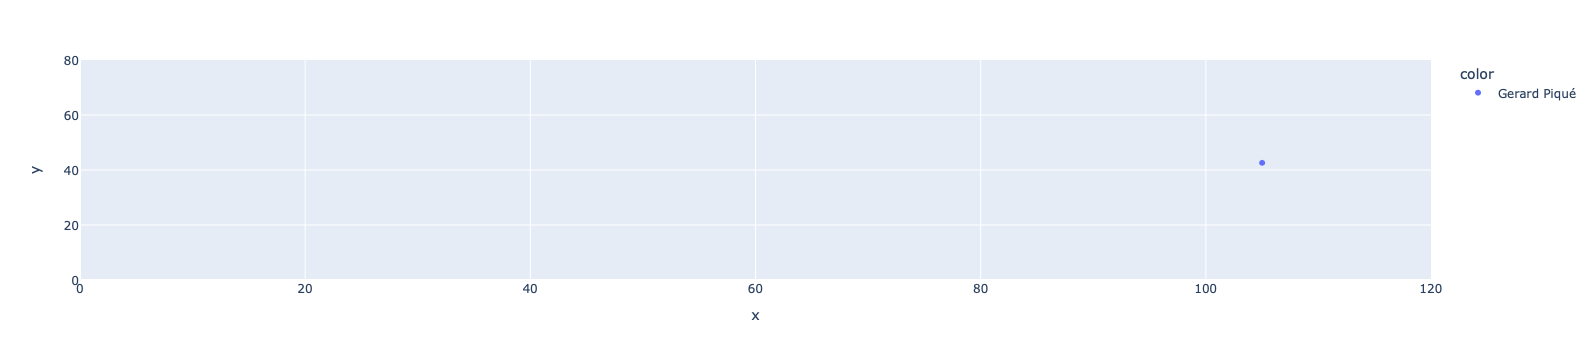

In [53]:
def get_player_shots(player:str, shots, dimensions):

    ## Scale x to dimensions
    shots['x'] = (shots['x'] - 0) / (shots['x'].max() - 0) * (dimensions.pitch_length_metres - 0) + 0
    #shots['y'] = (shots['y'] - 0) / (shots['y'].max() - 0) * (dimensions.pitch_width_metres - 0) + 0

    if player != 'All players':
        return shots[shots['player'] == player]

    return shots

player_shots = get_player_shots('Gerard Piqué', match_shots, DIMENSIONS)

fig = go.Figure(
    px.scatter(x=player_shots['x'], y=player_shots['y'], color=player_shots['player'])
)
               
fig.update_layout(yaxis_range=[0,80], xaxis_range=[0,120])
fig.show()

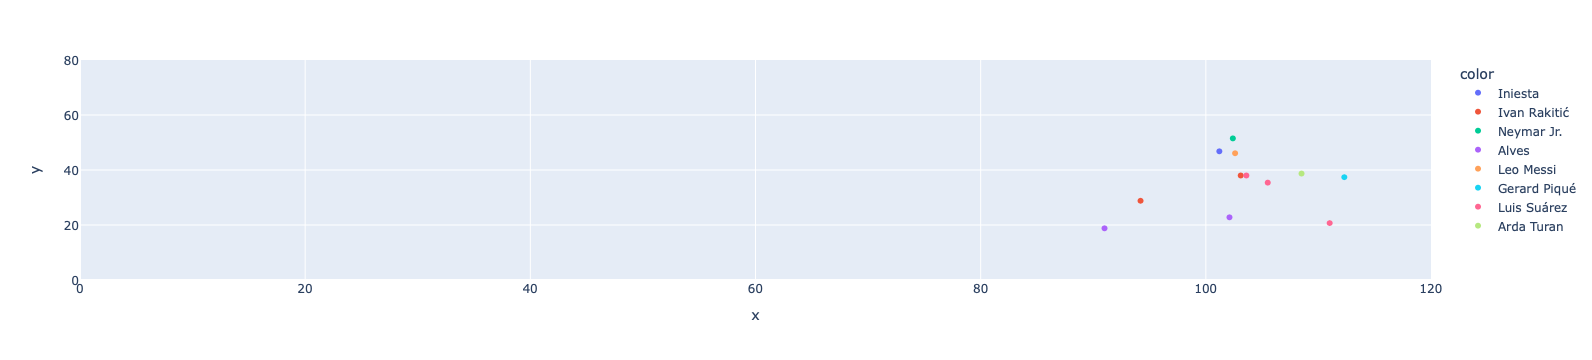

In [48]:
## Per statsbombpy, l'origen esta al corner de dalt a l'esquerra. Aixi, el corner de baix a l'esquerra és el punt (0, 80)
# Invertim y
match_shots['y'] = 80 - match_shots['y']
fig = go.Figure(
    px.scatter(x=match_shots['x'], y=match_shots['y'], color=match_shots['player'])
)
               
fig.update_layout(yaxis_range=[0,80], xaxis_range=[0,120])
fig.show()

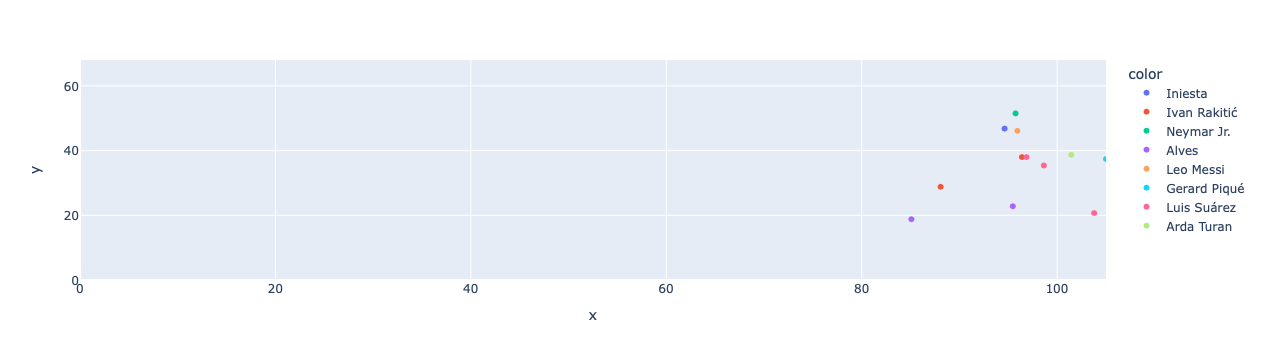

In [49]:

dimensions = PitchDimensions()
match_shots['x'] = (match_shots['x'] - 0) / (match_shots['x'].max() - 0) * (dimensions.pitch_length_metres - 0) + 0

fig = go.Figure(
    px.scatter(x=match_shots['x'], y=match_shots['y'], color=match_shots['player'])
)
               
fig.update_layout(yaxis_range=[0,68], xaxis_range=[0,105])
fig.show()

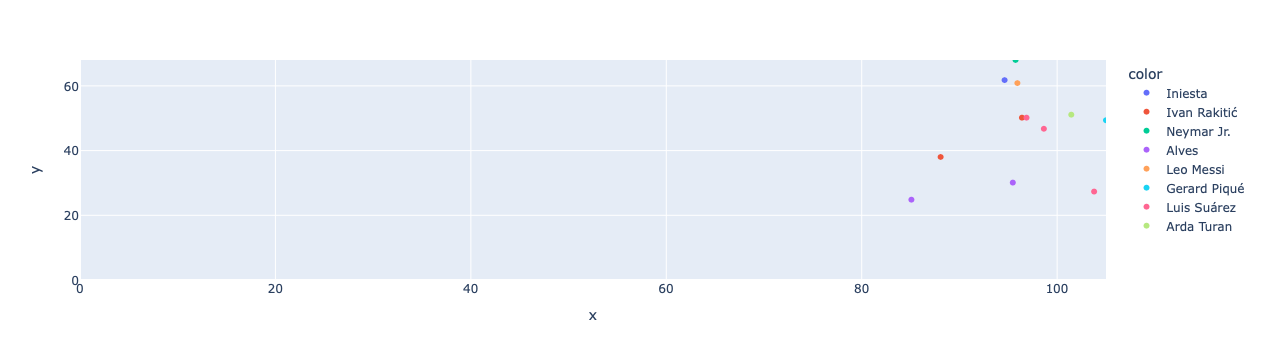

In [50]:
match_shots['y'] = (match_shots['y'] - 0) / (match_shots['y'].max() - 0) * (dimensions.pitch_width_metres - 0) + 0

fig = go.Figure(
    px.scatter(x=match_shots['x'], y=match_shots['y'], color=match_shots['player'])
)
               
fig.update_layout(yaxis_range=[0,68], xaxis_range=[0,105])
fig.show()

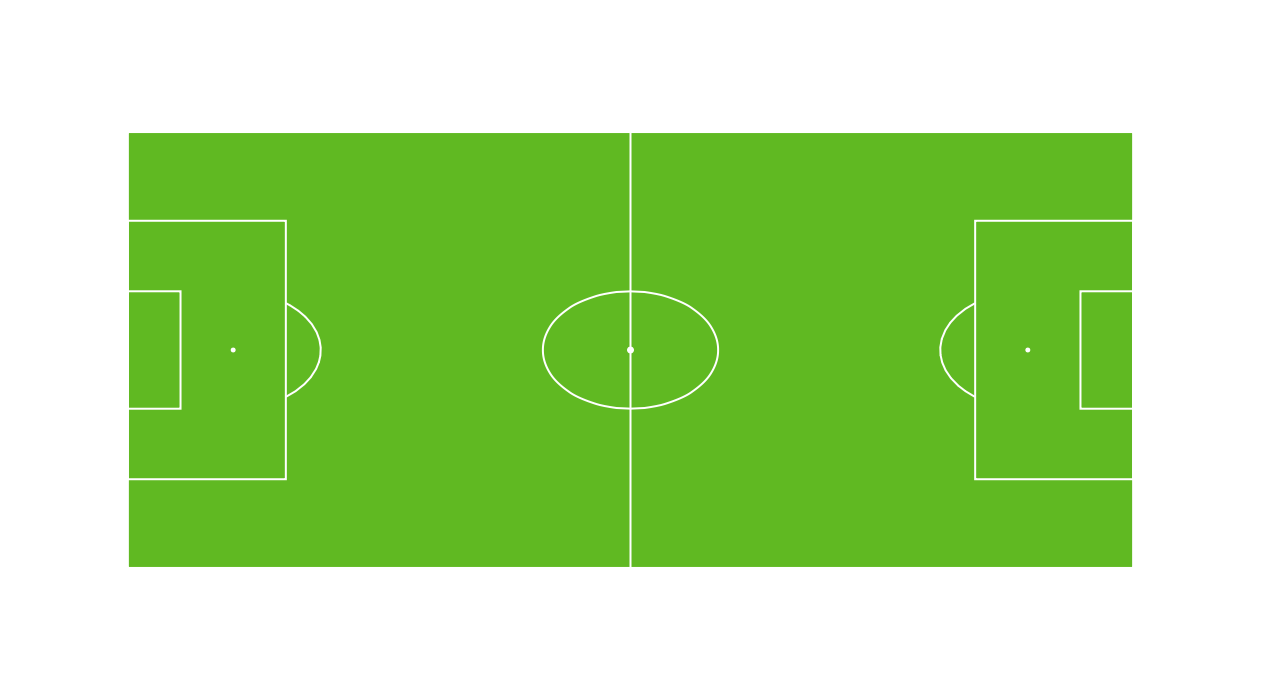

In [140]:
# Em fare el meu propi camp (0,0 al corner bottom-left)
import numpy as np

class FootballPitch():
    # ALL THE VALUES ARE IN METERS
    PITCH_LENGTH_METERS = 105
    PITCH_WIDTH_METERS = 68
    ZOOM_RATIO = 1
    HALF = False
    
    def __init__(self, 
                 pitch_length_meters = PITCH_LENGTH_METERS, 
                 pitch_width_meters = PITCH_WIDTH_METERS, 
                 half = HALF
                ):
        self.pitch_length = pitch_length_meters
        self.pitch_width = pitch_width_meters
        self._vertical_margin = 5
        self._horizontal_margin = 5
        self.half = half

        if self.half:
            self.pitch_length /= 2
        
    
    def plot_pitch(self, show=True, plot_corner_arcs=False, line_color='white', bg_color='#60b922', zoom_ratio = 1):
        # Fig to update
        fig = go.Figure()
        
        # Internal variables
        traces = []
        self.height_px = self.pitch_width*10*zoom_ratio
        self.width_px = self.pitch_length*10*zoom_ratio

        pitch_length_half = self.pitch_length/2 if not self.half else 0
        pitch_width_half = self.pitch_width/2
        corner_arc_radius = 1

        centre_circle_radius = 9.15
            
        goal = 7.32
        goal_area_width = goal + (5.5*2)
        goal_area_length = 5.5
        penalty_area_width = goal_area_width + (11*2)
        penalty_area_length = goal_area_length + 11
        penalty_spot_dist = 11
        penalty_circle_radius = 9.15

        # Pitch borders
        fig.add_trace(
            go.Scatter(
                x=[0, self.pitch_length, self.pitch_length, 0, 0], 
                y=[0, 0, self.pitch_width, self.pitch_width, 0], 
                mode='lines',
                #hoverinfo='skip',
                marker_color=line_color,
                showlegend=False,
                fill="toself",
                fillcolor=bg_color
            )
        )
        # Corner arcs (ACABAR ELIMINANTHO)
        if plot_corner_arcs:
            for degrees in range(0, 360, 90):
                theta = np.linspace(degrees*np.pi/180, (degrees+90)*np.pi/180, 5000)
                x = corner_arc_radius * np.cos(theta)
                y = corner_arc_radius * np.sin(theta)
                if degrees in [90, 180]:
                    x += self.pitch_length
                if degrees in [180, 270]:
                    y += self.pitch_width
                fig.add_trace(
                    go.Scatter(
                        x=x, y=y, mode='lines', marker_size=1, hoverinfo='skip', marker_color=line_color, showlegend=False
                    )
            )
        
        # Add half-way line, centre spot and arc
        halfway_line = go.Scatter(
            x=[pitch_length_half, pitch_length_half], 
            y=[0, self.pitch_width], 
            mode='lines',
            #hoverinfo='skip',
            marker_color=line_color,
            showlegend=False
        )
        centre_spot = go.Scatter(
            x=[pitch_length_half], 
            y=[pitch_width_half], 
            #hoverinfo='skip',
            marker_color=line_color,
            marker_size=7,
            showlegend=False
        )
        fig.add_shape(
            type="circle",
            xref="x", 
            yref="y",
            x0=pitch_length_half - centre_circle_radius, 
            y0=pitch_width_half - centre_circle_radius, 
            x1=pitch_length_half + centre_circle_radius, 
            y1=pitch_width_half + centre_circle_radius,
            line_color=line_color,
            showlegend=False
        )
        

        # Add all inside the penalty area
        goal_lines_to_plot = [0, self.pitch_length] if not self.half else [self.pitch_length]
        for goal_line_x in goal_lines_to_plot:
            # Goal area
            fig.add_trace(
                go.Scatter(
                    x=[goal_line_x, abs(goal_line_x-goal_area_length), abs(goal_line_x-goal_area_length), goal_line_x, goal_line_x],
                    y=[
                        pitch_width_half - (goal_area_width/2), pitch_width_half - (goal_area_width/2), 
                        pitch_width_half + (goal_area_width/2), pitch_width_half + (goal_area_width/2), 
                        pitch_width_half - (goal_area_width/2)
                    ], 
                    mode='lines',
                    #hoverinfo='skip',
                    marker_color=line_color,
                    showlegend=False
                )
            )

            # Penalty spot
            fig.add_trace(
                go.Scatter(
                    x=[abs(goal_line_x-penalty_spot_dist)], 
                    y=[pitch_width_half], 
                    #hoverinfo='skip',
                    marker_color=line_color,
                    marker_size=5,
                    showlegend=False
                )
            )

            # Penalty area
            fig.add_trace(
                go.Scatter(
                    x=[goal_line_x, abs(goal_line_x-penalty_area_length), abs(goal_line_x-penalty_area_length), goal_line_x, goal_line_x],
                    y=[
                        pitch_width_half - (penalty_area_width/2), pitch_width_half - (penalty_area_width/2), 
                        pitch_width_half + (penalty_area_width/2), pitch_width_half + (penalty_area_width/2), 
                        pitch_width_half - (penalty_area_width/2)
                    ], 
                    mode='lines',
                    #hoverinfo='skip',
                    marker_color=line_color,
                    showlegend=False
                )
            )

            # Penalty arc
            degree = 307 if goal_line_x == 0 else 127
            theta = np.linspace(degree*np.pi/180, (degree+106)*np.pi/180, 5000)
            x = penalty_circle_radius * np.cos(theta) + abs(goal_line_x-penalty_spot_dist)
            y = penalty_circle_radius * np.sin(theta) + pitch_width_half
            fig.add_trace(
                go.Scatter(
                    x=x, y=y, mode='lines', marker_size=1, hoverinfo='skip', marker_color=line_color, showlegend=False
                )
            )

        
        # Add the remaining traces
        for trace in [halfway_line, centre_spot]:
            fig.add_trace(trace)

        # Add final styles
        fig.update_layout(
            yaxis_range=[-self._vertical_margin, self.pitch_width + self._vertical_margin], 
            xaxis_range=[-self._horizontal_margin, self.pitch_length + self._horizontal_margin],
            height=self.height_px,
            width=self.width_px,
            plot_bgcolor='rgba(0,0,0,0)',
            xaxis=dict(showgrid=False, visible=False),
            yaxis=dict(showgrid=False, visible=False)
        )

        if show:
            fig.show()
        return fig

    
    def plot_heatmap(self, data: np.ndarray, **kwargs):
        if "colorscale" not in kwargs:
            kwargs["colorscale"] = px.colors.sequential.Reds[:1] + px.colors.sequential.Sunsetdark

        fig = self.plot_pitch(show=False, line_color='black', bg_color='rgba(0,0,0,0)')
        dx = self.pitch_length/ data.shape[1]
        dy = self.pitch_width / data.shape[0]
        
        heatmap = go.Heatmap(z=data,
                             dx=dx, dy=dy, y0=dy / 2, x0=dx / 2,
                             **kwargs
                            )
        fig.add_trace(heatmap)
        fig.update_layout(
            colorway=px.colors.sequential.Reds[:1]
        )
        
        return fig

pitch = FootballPitch(half=False)
pitch.plot_pitch(False)

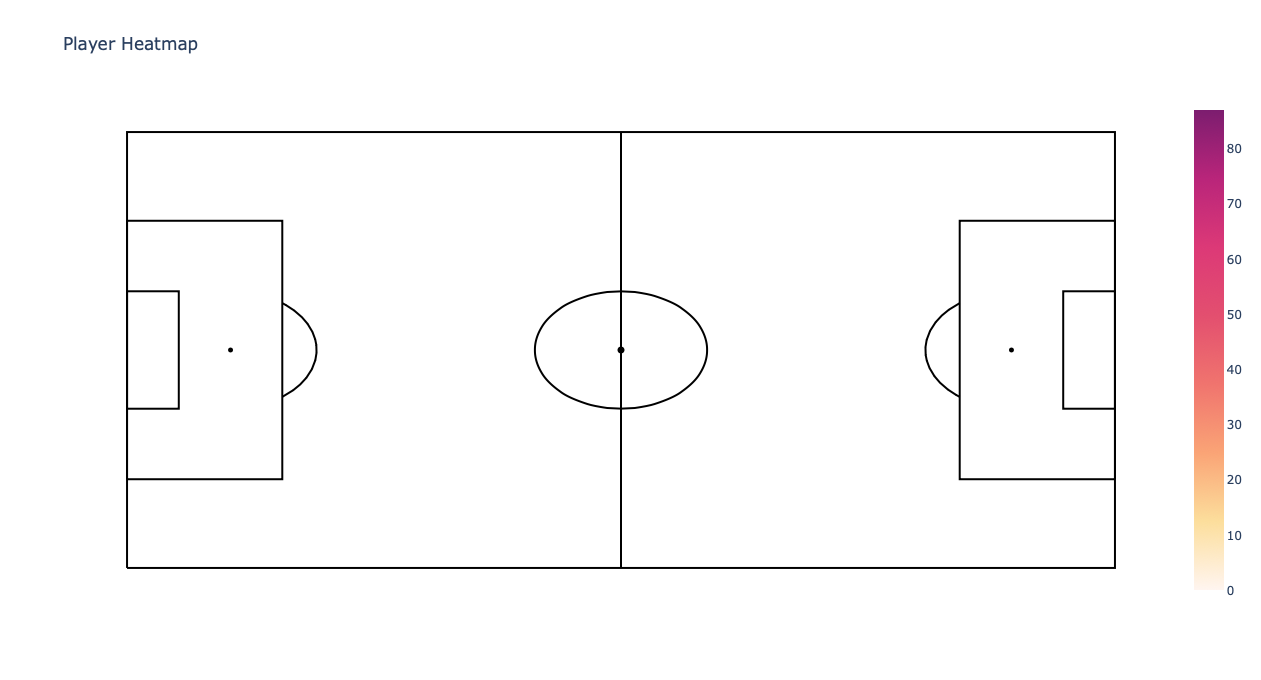

In [160]:
## PLAYER HEATMAP
div_factor = 3
player = 'Leo Messi'

pitch = FootballPitch(half=False)

# Potser puc treure les jugades a joc parat?
player_events = all_events[(all_events['player'] == player) & (~all_events['location'].isna())] 

player_events['x'] = player_events['x'] / (120 - 0) * (pitch.pitch_length if not pitch.half else pitch.pitch_length*2)
player_events['y'] = player_events['y'] / (80 - 0) * pitch.pitch_width
player_events['y'] = pitch.pitch_width - player_events['y']

player_events['x'] -= pitch.pitch_length if pitch.half else 0

xy = div_factor * (player_events[['x', 'y', 'minutes']]/div_factor).round()
xy = xy.groupby(['x', 'y']).count()[['minutes']]

data = np.empty(shape=(int(pitch.pitch_width)+div_factor, int(pitch.pitch_length)+div_factor))

data = []
for j in range(0, int(pitch.pitch_width), div_factor):
    for i in range(0, int(pitch.pitch_length), div_factor):
        #print(j, i)
        if i == 0 and j < pitch.pitch_width:
            data += [[]]
        if j < pitch.pitch_width:
            try:
                if (i, j) in xy.index:
                    data[int(j/div_factor)].append(xy.loc[(i,j)].values[0])
                else:
                    data[int(j/div_factor)].append(0)
            except:
                pass

data = np.asarray(data)
            
fig = pitch.plot_heatmap(data, zsmooth='best')
fig.update_layout(
    title='Player Heatmap',
)
fig.show()

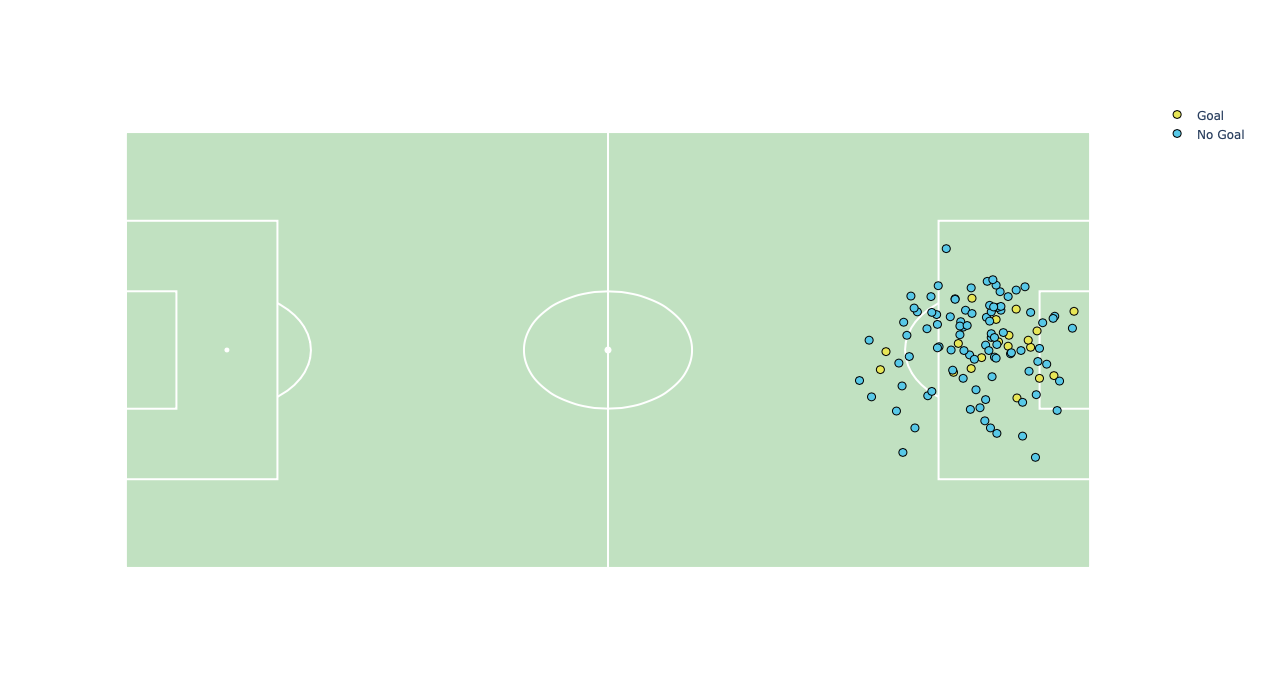

In [157]:
pitch = FootballPitch()
fig = pitch.plot_pitch(False, bg_color='#C1E1C1')

player = 'Leo Messi'

player_shots = shots[(shots['player'] == player)]  

player_shots['x'] = player_shots['x'] / (120 - 0) * (pitch.pitch_length if not pitch.half else pitch.pitch_length*2)
player_shots['y'] = player_shots['y'] / (80 - 0) * pitch.pitch_width
player_shots['y'] = pitch.pitch_width - player_shots['y']

player_shots['x'] -= pitch.pitch_length if pitch.half else 0

scatter_colors = ["#E7E657", "#57C8E7"]

for i, group in enumerate([True, False]):

    color_index = len(color_scale)-1-i if i%2 == 0 else i
    
    fig.add_trace(go.Scatter(
        x=player_shots[player_shots['goal'] == group]['x'],
        y=player_shots[player_shots['goal'] == group]['y'],
        mode="markers",
        name='Goal' if group else 'No Goal',
        marker=dict(
            color=scatter_colors[i],
            size=8,
            line=dict(
                color='black',
                width=1
            )
        ),
        #marker_color=scatter_colors[i] # #E7E657 i #57C8E7  
    ))

fig.show()

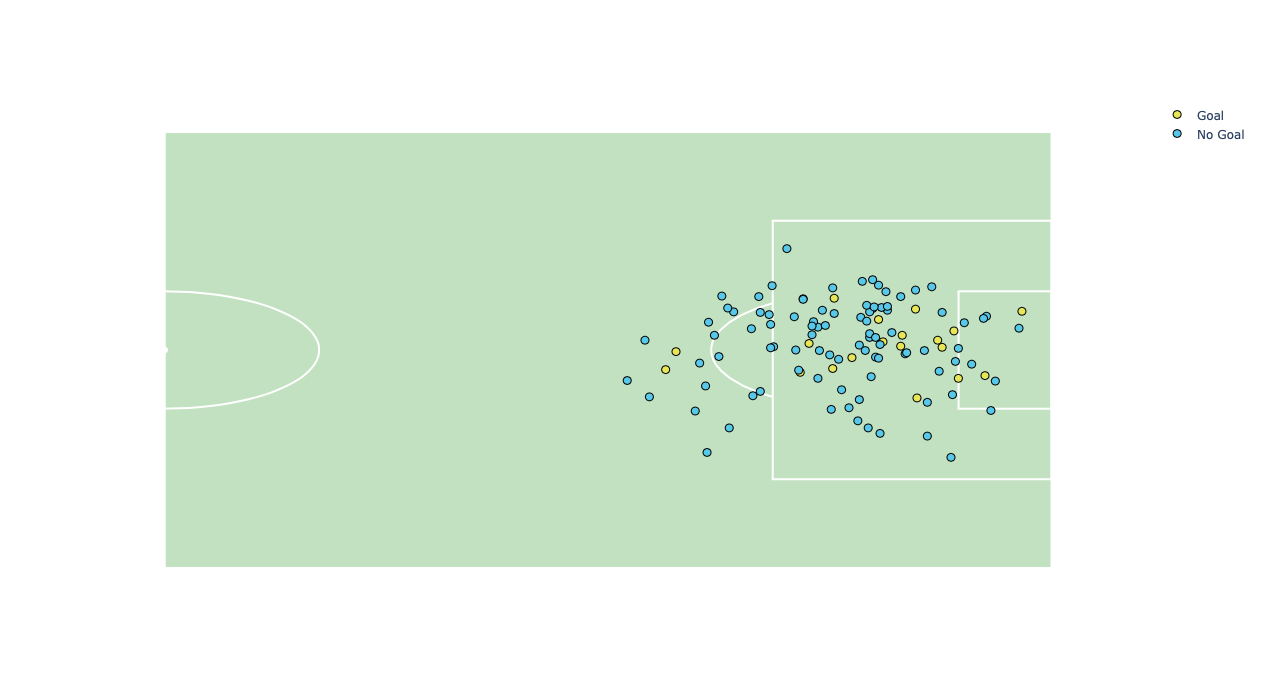

In [158]:
pitch = FootballPitch(half=True)
fig = pitch.plot_pitch(False, bg_color='#C1E1C1') 

player = 'Leo Messi'

player_shots = shots[(shots['player'] == player)]  

player_shots['x'] = player_shots['x'] / (120 - 0) * (pitch.pitch_length if not pitch.half else pitch.pitch_length*2)
player_shots['y'] = player_shots['y'] / (80 - 0) * pitch.pitch_width
player_shots['y'] =  pitch.pitch_width - player_shots['y']

player_shots['x'] -= pitch.pitch_length if pitch.half else 0

scatter_colors = ["#E7E657", "#57C8E7"]

for i, group in enumerate([True, False]):

    color_index = len(color_scale)-1-i if i%2 == 0 else i
    
    fig.add_trace(go.Scatter(
        x=player_shots[player_shots['goal'] == group]['x'],
        y=player_shots[player_shots['goal'] == group]['y'],
        mode="markers",
        name='Goal' if group else 'No Goal',
        marker=dict(
            color=scatter_colors[i],
            size=8,
            line=dict(
                color='black',
                width=1
            )
        ),
        #marker_color=scatter_colors[i] # #E7E657 i #57C8E7  
    ))

fig.show()

In [162]:
#all_events.columns
all_events['pass_shot_assist'].unique()

array([nan, True], dtype=object)